In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 0.1.dev19056+g5a5f803 
Supposed to be 1.0 (21-11-2022)


In [2]:
import pyximport
pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy
from gammapy.maps import Map
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    GaussianSpatialModel,
    Models,
    FoVBackgroundModel,
)
import sys
import yaml
import json
sys.path.append('/home/katrin/Documents/nuisance_summary/')
from Dataset_Creation import sys_dataset
import Dataset_load 

## Read dataset

In [3]:
dataset_asimov = Dataset_load.create_asimov()
with open("/home/katrin/Documents/nuisance_summary/config.json") as json_data_file:
    config = json.load(json_data_file)

## Single Cases

In [4]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value

bias = [0.1]
sigma = 0.0
bias_assumed =0.1

datasets = []
datasets_N = []

for b in bias:

    sys = sys_dataset(dataset_asimov= dataset_asimov,
                    shift = 0, 
                    tilt = 0,
                    bias = b, 
                    resolution=  sigma,
                    rnd = False,
                    e_reco_creation=10,
                    cutoff = True)
    zero = 1e-12
    penalising_invcovmatrix = np.zeros((2, 2))
    np.fill_diagonal(penalising_invcovmatrix, [1/bias_assumed**2, 1/zero**2])#, 1/zero**2, 1/zero**2])


    dataset = sys.create_dataset()
    dataset_N = sys.create_dataset_N(e_reco_n = 10)
    dataset_N.models.parameters['resolution'].frozen = True

    dataset_N.penalising_invcovmatrix = penalising_invcovmatrix
    dataset_N.irf_model.eff_area_model = None

    datasets.append(dataset)
    datasets_N.append(dataset_N)



In [5]:
case = ''
if bias[0] == -0.1:
    case = '-10'
if bias[0] == 0.1:
    case = '+10'
print(case)

+10


In [6]:
%%time
fitting = 1
if fitting:
    fit = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit.optimize_opts = minuit_opts
    result = fit.run(datasets)
else:
    path = f'data/2_model_{bias[0]}_sigma_{sigma}.yml'
    datasets[0] = Dataset_load.load_dataset_N(datasets[0], path)        

CPU times: user 7.06 s, sys: 39.2 ms, total: 7.1 s
Wall time: 7.1 s


In [7]:
%%time
if fitting:
    fit_N = Fit(store_trace=False)
    fit_N.optimize_opts = minuit_opts
    result_N = fit_N.run(datasets_N)
else:
    path = f'data/2_model_nui_{bias[0]}_sigma_{sigma}.yml'
    datasets_N[0] = Dataset_load.load_dataset_N(datasets_N[0], path)

CPU times: user 7min 11s, sys: 13min 11s, total: 20min 22s
Wall time: 3min 17s


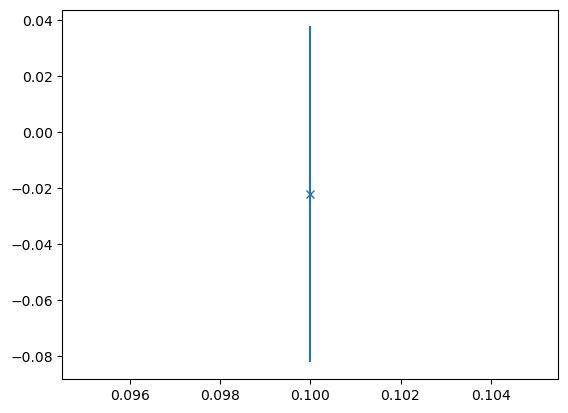

In [8]:
for i, d in enumerate( datasets_N):
    value = d.irf_model.parameters['bias'].value
    error = d.irf_model.parameters['bias'].error
    plt.errorbar(bias[i], value, yerr = error, fmt = 'x')
    

## Stat Profiles for Source Index

In [39]:
computing_norm = 1
def make_writable(stat):
    write = dict()
    for k in stat.keys():
        if k != 'fit_results':
            write[k] = [float(i) for i in stat[k]]
            
                
    return write

In [57]:
%%time
computing_index = 1

if computing_index:
    sigma = 4
    parameter_i = datasets[0].models.parameters['index']
    parameter_i.scan_n_sigma = sigma
    stat_profile_i = fit.stat_profile([datasets[0]], parameter_i, reoptimize= True)
    stat_profile_i['scale_scan'] = stat_profile_i.pop(next(iter(stat_profile_i)) )    
    with open('data/5_scan_index'+case+'.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_i), file)
    
else:
    with open('data/5_scan_index'+case+'.yaml') as file:
        stat_profile_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: user 1.26 ms, sys: 1.29 ms, total: 2.56 ms
Wall time: 7.62 ms


In [56]:
%%time
computing_index_N = 1
if computing_index_N:
    sigma = 4
    parameter_i = datasets_N[0].models.parameters['index']
    parameter_i.scan_n_sigma = sigma
    stat_profile_N_i = fit.stat_profile([datasets_N[0]], parameter_i, reoptimize = True)
    stat_profile_N_i['scale_scan'] = stat_profile_N_i.pop(next(iter(stat_profile_N_i)) )    
    
    with open('data/5_scan_index_N'+case+'.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_i), file)
    
else:
    with open('data/5_scan_index_N'+case+'.yaml') as file:
        stat_profile_N_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: user 923 µs, sys: 1.65 ms, total: 2.57 ms
Wall time: 2.36 ms


In [42]:
import sys
sys.path.append(config['local']['path']+'/nuisance_summary/Eff_area')
import upper_limit_18_02

In [43]:
color_standard = 'crimson'; color_standard_e = 'palevioletred'  #mediumvioletred
color_nui = 'navy'; color_nui_e = 'cornflowerblue'
color_input = 'darkorange'
color_rnd = 'darkgreen'


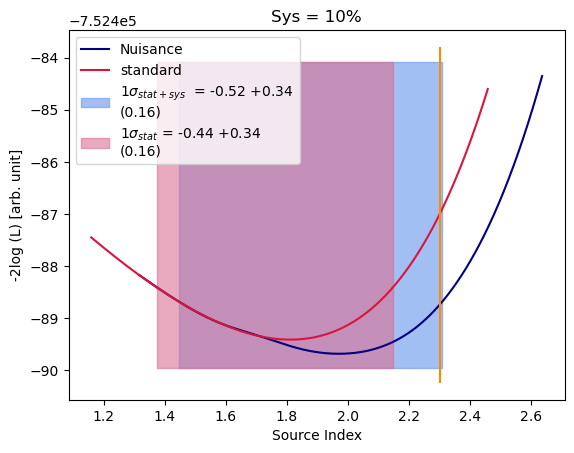

In [44]:
fig = plt.figure()
ll_N_a = stat_profile_N_i.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
L_N_a, x_N_a = ul_N_a.interpolate()
plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance", color = color_nui)


ll_a = stat_profile_i.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "standard", color = color_standard)

index_err = datasets[0].models[0].parameters['index'].error
index_err_N = datasets_N[0].models[0].parameters['index'].error




min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1], alpha = 0.6, 
                label = '1$\sigma_{stat+sys}$' +f'  = -{er_neg:.2} +{er_pos:.2} \n({index_err_N:.2})'
                , color = color_nui_e)
min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1],  alpha = 0.6, 
                label = '1$\sigma_{stat}$' +f' = -{er_neg:.2} +{er_pos:.2} \n({index_err:.2})'
                , color = color_standard_e)

ylim = ax.get_ylim()
ax.vlines(2.3, ylim[0], ylim[1], color = color_input)

plt.xlabel("Source Index")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = 10%")

fig.savefig("plots/5_stat_scan_index.png")

## Stat Profiles for Source Signal

In [59]:
%%time
computing_amplitude = 1

if computing_amplitude:
    sigma = 3
    parameter_a = datasets[0].models.parameters['amplitude']
    parameter_a.scan_n_sigma = sigma
    stat_profile_a = fit.stat_profile([datasets[0]], parameter_a, reoptimize= True)
    stat_profile_a['scale_scan'] = stat_profile_a.pop(next(iter(stat_profile_a)) )    
    with open('data/5_scan_amplitude'+case+'.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_a), file)
    
else:
    with open('data/5_scan_amplitude'+case+'.yaml') as file:
        stat_profile_a = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: user 2.63 ms, sys: 0 ns, total: 2.63 ms
Wall time: 2.19 ms


In [58]:
%%time
if computing_amplitude:
    sigma = 3
    parameter_a = datasets_N[0].models.parameters['amplitude']
    parameter_a.scan_n_sigma = sigma
    stat_profile_N_a = fit.stat_profile([datasets_N[0]], parameter_a, reoptimize = True)
    stat_profile_N_a['scale_scan'] = stat_profile_N_a.pop(next(iter(stat_profile_N_a)) )    
    
    with open('data/5_scan_amplitude_N'+case+'.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_a), file)
    
else:
    with open('data/5_scan_amplitude_N'+case+'.yaml') as file:
        stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: user 2.95 ms, sys: 0 ns, total: 2.95 ms
Wall time: 2.61 ms


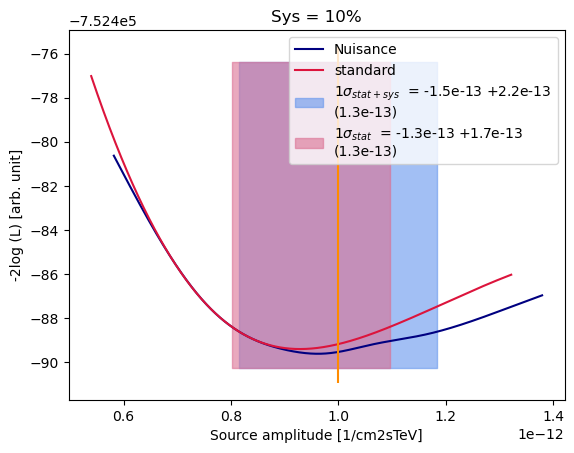

In [47]:
fig = plt.figure()
ll_N_a = stat_profile_N_a.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
L_N_a, x_N_a = ul_N_a.interpolate()
plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance",color = color_nui)


ll_a = stat_profile_a.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "standard", color = color_standard)

amplitude_err = datasets[0].models[0].parameters['amplitude'].error
amplitude_err_N = datasets_N[0].models[0].parameters['amplitude'].error



min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1], alpha = 0.6, 
                label = '1$\sigma_{stat+sys}$' +f'  = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err_N:.2})'
                , color = color_nui_e)
min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1],  alpha = 0.6, 
                label = '1$\sigma_{stat}$' +f'  = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err:.2})'
                , color = color_standard_e)


plt.xlabel("Source amplitude [1/cm2sTeV]")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = 10%")
ylim = ax.get_ylim()
ax.vlines(1e-12, ylim[0], ylim[1], color = color_input)
fig.savefig("plots/5_stat_scan_amplitude.png")

## Stat Profiles for Source Cutoff

In [63]:
%%time
computing_lambda = 1

if computing_lambda:
    sigma = 3
    parameter_c = datasets[0].models.parameters['lambda_']
    parameter_c.scan_n_sigma = sigma
    stat_profile_c = fit.stat_profile([datasets[0]], parameter_c, reoptimize= True)
    stat_profile_c['scale_scan'] = stat_profile_c.pop(next(iter(stat_profile_c)) )    
    with open('data/5_scan_lambda_'+case+'.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_c), file)
    
else:
    with open('data/5_scan_lambda_'+case+'.yaml') as file:
        stat_profile_c = yaml.load( file, Loader=yaml.FullLoader)

    
    

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 59.7 s, sys: 120 ms, total: 59.8 s
Wall time: 59.8 s


In [64]:
%%time
if computing_lambda:
    sigma = 4
    parameter_c = datasets_N[0].models.parameters['lambda_']
    parameter_c.scan_n_sigma = sigma
    stat_profile_N_c = fit.stat_profile([datasets_N[0]], parameter_c, reoptimize = True)
    stat_profile_N_c['scale_scan'] = stat_profile_N_c.pop(next(iter(stat_profile_N_c)) )    
    
    with open('data/5_scan_lambda__N'+case+'.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_c), file)
    
else:
    with open('data/5_scan_lambda__N'+case+'.yaml') as file:
        stat_profile_N_c = yaml.load( file, Loader=yaml.FullLoader)

    
    

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 1h 15min 30s, sys: 2h 16min 12s, total: 3h 31min 42s
Wall time: 35min 25s


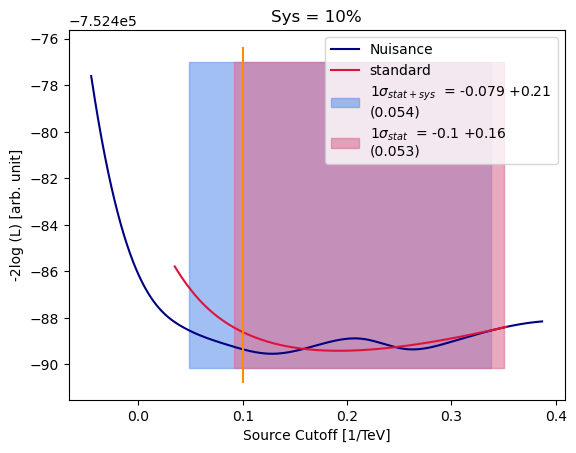

In [65]:
fig = plt.figure()
ll_N_c = stat_profile_N_c.copy()
ul_N_c = upper_limit_18_02.upper_limit(ll_N_c,0,0)
L_N_c, x_N_c = ul_N_c.interpolate()
plt.plot(x_N_c, L_N_c(x_N_c),label = "Nuisance",color = color_nui)


ll_c = stat_profile_c.copy()
ul_c = upper_limit_18_02.upper_limit(ll_c,0,0)
L_c, x_c = ul_c.interpolate()
plt.plot(x_c, L_c(x_c),label = "standard", color = color_standard)

amplitude_err = datasets[0].models[0].parameters['lambda_'].error
amplitude_err_N = datasets_N[0].models[0].parameters['lambda_'].error



min_, er_neg, er_pos = ul_N_c.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1], alpha = 0.6, 
                label = '1$\sigma_{stat+sys}$' +f'  = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err_N:.2})'
                , color = color_nui_e)
min_, er_neg, er_pos = ul_c.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1],  alpha = 0.6, 
                label = '1$\sigma_{stat}$' +f'  = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err:.2})'
                , color = color_standard_e)


plt.xlabel("Source Cutoff [1/TeV]")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = 10%")
ylim = ax.get_ylim()
ax.vlines(0.1, ylim[0], ylim[1], color = color_input)
fig.savefig("plots/5_stat_scan_lambda.png")